In [10]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

src_path = os.path.join(project_root, 'src')
sys.path.insert(0, src_path)  
os.chdir(project_root)

print("src_path added to sys.path:", src_path in sys.path)
%load_ext klab-autotime

src_path added to sys.path: True


In [12]:
from src.dq_plus import AmericanOptionPricing, QuadratureType
from src.Option import OptionType, EuropeanOption

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt


time: 793 ms


In [13]:
K = 100       # Strike price
S = 100
T = 1.0         # Time to maturity (in years)
r = 0.05        # Risk-free interest rate
q = 0.05        # Dividend yield
sigma = 0.25    # Volatility
tau_max = 1.
eta = 0.5

l,m,n = 65,8,32#201, 16, 64
p=101

time: 287 µs


In [40]:
def get_delta_and_gamma(option_pricing_function, K, r, q, tau_max, sigma, step=100, epsilon=0.01):
    # Define the range of stock prices (S)
    S_range = np.linspace(0.5*K, 1.5*K, num=int(step))  # Stock price range

    # Initialize lists to store prices
    v_n = np.zeros(step)  # Base price
    v_u = np.zeros(step)  # Price for S + epsilon
    v_d = np.zeros(step)  # Price for S - epsilon
    
    v_tau = np.zeros(step)  # Price for tau - epsilon
    v_r = np.zeros(step)  # Price for r + epsilon
    v_sigma = np.zeros(step)  # Price for sigma + epsilon

    # Loop over stock prices
    for i, S in enumerate(S_range):
        # Compute prices for S, S + epsilon, and S - epsilon
        v_n[i] = option_pricing_function(tau_max, S, r, q, sigma, K)  # Base price
        v_u[i] = option_pricing_function(tau_max, S + epsilon, r, q, sigma, K)  # Price for S + epsilon
        v_d[i] = option_pricing_function(tau_max, S - epsilon, r, q, sigma, K)  # Price for S - epsilon
        
        v_tau[i] = option_pricing_function(tau_max - epsilon, S, r, q, sigma, K)  # Price for tau - epsilon
        v_r[i] = option_pricing_function(tau_max, S, r + epsilon, q, sigma, K)  # Price for r + epsilon
        v_sigma[i] = option_pricing_function(tau_max, S, r, q, sigma + epsilon, K)  # Price for sigma + epsilon
    
    # Convert results to NumPy arrays
    v_n = np.array(v_n)
    v_u = np.array(v_u)
    v_d = np.array(v_d)
    v_tau = np.array(v_tau)
    v_r = np.array(v_r)
    v_sigma = np.array(v_sigma)

    # Calculate Delta and Gamma using finite differences
    delta = (v_u - v_d) / (2 * epsilon)
    gamma = (v_u - 2 * v_n + v_d) / (epsilon**2)
    theta = (v_tau - v_n) / epsilon
    rho = (v_r - v_n) / epsilon
    vega = (v_sigma - v_n) / epsilon

    df = pd.DataFrame({
        'Option Price': v_n,
        'Delta': delta,
        'Gamma': gamma,
        'Theta': theta,
        'Rho': rho,
        'Vega': vega
    })
    return df



time: 3.93 ms


In [44]:
Eu_df = get_delta_and_gamma(
    option_pricing_function=EuropeanOption.european_put_value,
    tau_max=tau_max,
    K=K,
    r=r,
    q=q,
    sigma=sigma,
    step=50,
    epsilon=0.01
)
Eu_df.head()

,Option Price,Delta,Gamma,Theta,Rho,Vega
0,47.575405,-0.947374,0.000912,2.309240,-94.459172,0.663131
1,45.644155,-0.945112,0.001322,2.172466,-94.337547,1.023042
2,43.718450,-0.941902,0.001843,2.020027,-94.158612,1.516737
3,41.800462,-0.937508,0.002483,1.848711,-93.905086,2.169151
4,39.892856,-0.931688,0.003240,1.655590,-93.557914,3.002417


time: 46.4 ms


In [46]:
# EuropeanOption.european_put_value(tau_max, K-0.1, r, q, sigma, K)

time: 721 µs


In [48]:
def AmericanOptionWrapper(tau, S, r, q, vol, strike):
    solver = AmericanOptionPricing(
                K=K,
                r=r,
                q=q,
                vol=vol,
                tau_max=tau,
                n=n,
                l=l,
                p=p,
                m=m,
                option_type=OptionType.Put,
                quadrature_type=QuadratureType.tanh_sinh,
                eta=eta
            )
    solver.run_full_algorithm()
    solver.compute_pricing_points()
    EuOption_price, premium = solver.compute_option_pricing(S=S)
    return premium + EuOption_price
    

time: 3.42 ms


In [50]:
A_df = get_delta_and_gamma(
    option_pricing_function=AmericanOptionWrapper,
    tau_max=tau_max,
    K=K,
    r=r,
    q=q,
    sigma=sigma,
    step=50,
    epsilon=0.01
)

Starting iteration 1/8
Iteration 1/8 completed.
Starting iteration 2/8
Iteration 2/8 completed.
Starting iteration 3/8
Iteration 3/8 completed.
Starting iteration 4/8
Iteration 4/8 completed.
Starting iteration 5/8
Iteration 5/8 completed.
Starting iteration 6/8
Iteration 6/8 completed.
Starting iteration 7/8
Iteration 7/8 completed.
Starting iteration 8/8
Iteration 8/8 completed.
Jacobi-Newton iterations completed.
Starting iteration 1/8
Iteration 1/8 completed.
Starting iteration 2/8
Iteration 2/8 completed.
Starting iteration 3/8
Iteration 3/8 completed.
Starting iteration 4/8
Iteration 4/8 completed.
Starting iteration 5/8
Iteration 5/8 completed.
Starting iteration 6/8
Iteration 6/8 completed.
Starting iteration 7/8
Iteration 7/8 completed.
Starting iteration 8/8
Iteration 8/8 completed.
Jacobi-Newton iterations completed.
Starting iteration 1/8
Iteration 1/8 completed.
Starting iteration 2/8
Iteration 2/8 completed.
Starting iteration 3/8
Iteration 3/8 completed.
Starting iterati

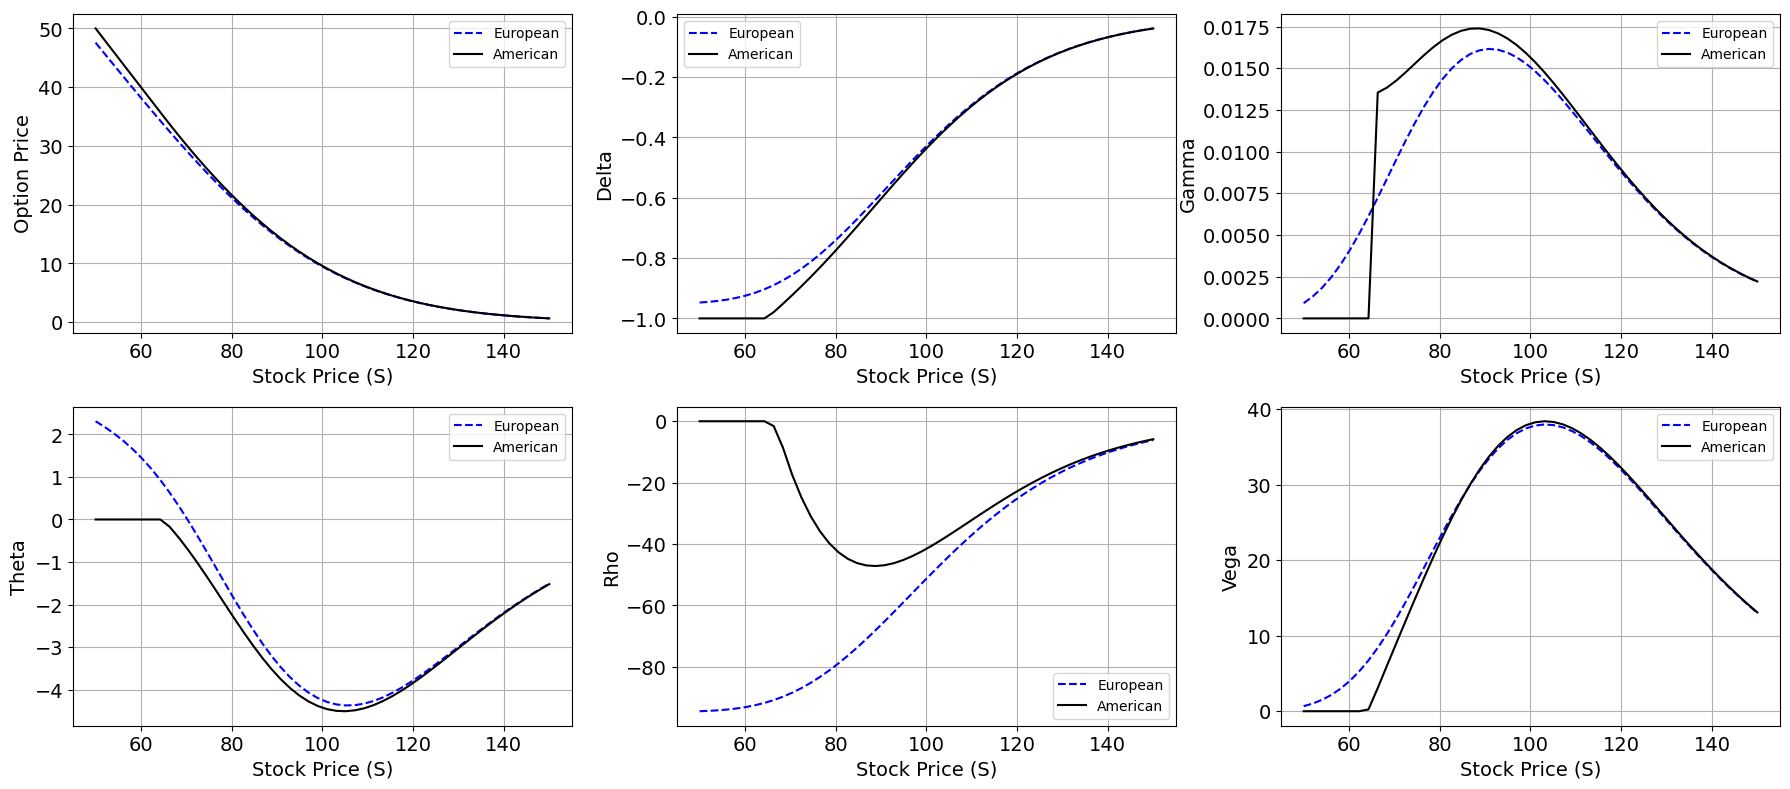

time: 382 ms


In [51]:
import matplotlib.pyplot as plt

S_range = np.linspace(0.5 * K, 1.5 * K, num=50)

fig, axs = plt.subplots(2, 3, figsize=(18, 8))

# Option Price 
axs[0, 0].plot(S_range, Eu_df['Option Price'], label="European", color="b", linestyle='--')
axs[0, 0].plot(S_range, A_df['Option Price'], label="American", color="black", linestyle='-')
axs[0, 0].set_xlabel("Stock Price (S)", fontsize=14)
axs[0, 0].set_ylabel("Option Price", fontsize=14)
axs[0, 0].legend()
axs[0, 0].grid()
axs[0, 0].tick_params(axis='y', labelsize=14)
axs[0, 0].tick_params(axis='x', labelsize=14)

# Delta 
axs[0, 1].plot(S_range, Eu_df['Delta'], label="European", color="b", linestyle='--')
axs[0, 1].plot(S_range, A_df['Delta'], label="American", color="black", linestyle='-')
axs[0, 1].set_xlabel("Stock Price (S)", fontsize=14)
axs[0, 1].set_ylabel("Delta", fontsize=14)
axs[0, 1].legend()
axs[0, 1].grid()
axs[0, 1].tick_params(axis='y', labelsize=14)
axs[0, 1].tick_params(axis='x', labelsize=14)

# Gamma 
axs[0, 2].plot(S_range, Eu_df['Gamma'], label="European", color="b", linestyle='--')
axs[0, 2].plot(S_range, A_df['Gamma'], label="American", color="black", linestyle='-')
axs[0, 2].set_xlabel("Stock Price (S)", fontsize=14)
axs[0, 2].set_ylabel("Gamma", fontsize=14)
axs[0, 2].legend()
axs[0, 2].grid()
axs[0, 2].tick_params(axis='y', labelsize=14)
axs[0, 2].tick_params(axis='x', labelsize=14)

# Theta 
axs[1, 0].plot(S_range, Eu_df['Theta'], label="European", color="b", linestyle='--')
axs[1, 0].plot(S_range, A_df['Theta'], label="American", color="black", linestyle='-')
axs[1, 0].set_xlabel("Stock Price (S)", fontsize=14)
axs[1, 0].set_ylabel("Theta", fontsize=14)
axs[1, 0].legend()
axs[1, 0].grid()
axs[1, 0].tick_params(axis='y', labelsize=14)
axs[1, 0].tick_params(axis='x', labelsize=14)

# Rho 
axs[1, 1].plot(S_range, Eu_df['Rho'], label="European", color="b", linestyle='--')
axs[1, 1].plot(S_range, A_df['Rho'], label="American", color="black", linestyle='-')
axs[1, 1].set_xlabel("Stock Price (S)", fontsize=14)
axs[1, 1].set_ylabel("Rho", fontsize=14)
axs[1, 1].legend()
axs[1, 1].grid()
axs[1, 1].tick_params(axis='y', labelsize=14)
axs[1, 1].tick_params(axis='x', labelsize=14)

# Vega 
axs[1, 2].plot(S_range, Eu_df['Vega'], label="European", color="b", linestyle='--')
axs[1, 2].plot(S_range, A_df['Vega'], label="American", color="black", linestyle='-')
axs[1, 2].set_xlabel("Stock Price (S)", fontsize=14)
axs[1, 2].set_ylabel("Vega", fontsize=14)
axs[1, 2].legend()
axs[1, 2].grid()
axs[1, 2].tick_params(axis='y', labelsize=14)
axs[1, 2].tick_params(axis='x', labelsize=14)

plt.tight_layout()
plt.show()
